In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats
import scipy
import glob

In [2]:
%matplotlib notebook
plt.style.use('seaborn')

In [3]:
#where the results are located...now look under Hessian_visualization/data/1852 in the local directory
inDir='/groups/SIAllocation/tsunami/1852_results/24k-runs'
#chains
# chains = os.listdir(inDir)
dirs = glob.glob(inDir+"/3*/")

In [4]:
#read in data
nburn=19000 #rows to skip at the start of each chain

samples = []
model_params = []
model_output = []
bayes_data = []
debug = []
data = (['samples','model_params','model_output','bayes_data','debug'],
             [samples,model_params,model_output,bayes_data,debug])

for dir_ in dirs:
    for kind,lst in zip(*data):
        k=nburn+1
        if kind=='debug':
            k=nburn
        df = pd.read_csv(dir_+kind+'.csv',index_col=0).iloc[k:].reset_index(drop=True)
#         df['chain_id'] = dir_[:-4]
        lst.append(df)

In [5]:
[ len(df) for df in samples ]

[5000,
 5000,
 5000,
 5000,
 5000,
 5000,
 5000,
 5000,
 5000,
 5000,
 5000,
 5000,
 5000,
 5000]

In [6]:
#read in data
#dfs = [ pd.read_csv(inDir+"/"+chain+"/samples.csv") for chain in chains ]
samples[0].head()

,latitude,longitude,magnitude,delta_logl,delta_logw,depth_offset
0,-4.131395,131.290603,8.800251,-0.039959,-0.159073,6.802103
1,-4.131395,131.290603,8.800251,-0.039959,-0.159073,6.802103
2,-4.131395,131.290603,8.800251,-0.039959,-0.159073,6.802103
3,-4.131395,131.290603,8.800251,-0.039959,-0.159073,6.802103
4,-4.131395,131.290603,8.800251,-0.039959,-0.159073,6.802103


In [7]:
#Get a particular attribute and stack it into a single array
attr='magnitude'
nthin=10   #optional thinning to reduce computational cost during testing

f = np.concatenate([ df[attr].values for df in samples ])
f = f[::nthin]
len(f)

7000

In [8]:
# #alternative way of reading in
# chains = os.listdir(inDir)
# dfs = [ pd.read_csv(inDir+"/"+chain+"/samples.csv") for chain in chains ]
# attr='magnitude'
# nburn=6001 #rows to skip at the start of each chain
# nthin=10   #optional thinning to reduce computational cost during testing

# f = np.concatenate([ df[attr].values[nburn:] for df in dfs ])
# f = f[::nthin]
# len(f)

# Dupuis #

Now we turn to error bounds from Dupuis: https://epubs.siam.org/doi/10.1137/15M1025645

(See also https://arxiv.org/abs/1503.05136, though some equation numbers vary there)

## Bound in terms of R(Q||P) from Section 2.2

Dupuis Equations (2.9) and (2.10):
$$
\mathbb{E}_{Q}[f] − \mathbb{E}_{P}[f] \le \frac{1}{c} \log \mathbb{E}_{P}\left[e^{c(f −\mathbb{E}_{P} [f])}\right] + \frac{1}{c} \mathcal{R} (Q || P ) \\
\mathbb{E}_{Q}[f] − \mathbb{E}_{P}[f] \ge -\frac{1}{c} \log \mathbb{E}_{P}\left[e^{-c(f −\mathbb{E}_{P} [f])}\right] - \frac{1}{c} \mathcal{R} (Q || P )
$$

In [9]:
#Equations (2.9) and (2.10)

c = 1

EPf = f.mean() #E_P[f]
expCdelF = np.exp( c*(f-EPf) )  #e^{c*(f-E_P[f])}
ubT1 =  np.log(    expCdelF.mean())/c #1st term of 2.9  (upper bound)
lbT1 = -np.log((1/expCdelF).mean())/c #1st term of 2.10 (lower bound)

print('range on E('+attr+') from variance in posterior is: ['+str(EPf+lbT1)+', '+str(EPf+ubT1)+']')
print('**note that this ignores the R(Q||P) term**')

range on E(magnitude) from variance in posterior is: [8.82809890184515, 8.835654168104854]
**note that this ignores the R(Q||P) term**


<IPython.core.display.Javascript object>


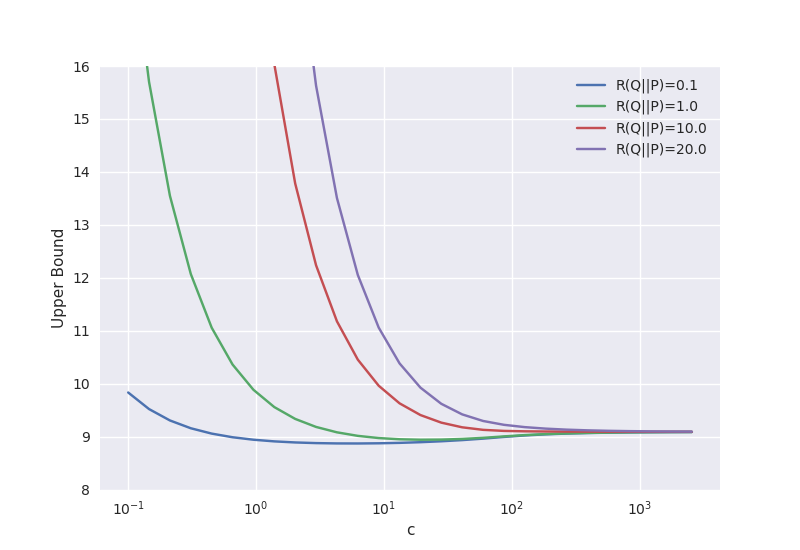

In [10]:
#Show the relationship between the upper bound and c for changing R 

#list of c's to try
#cs = np.power(10.0,np.arange(-3,3))
cs = np.logspace(-1,7)
Rs = [0.1,1.0,10.0,20.0]

#precompute some things
EPf = f.mean() #E_P[f]
ft  = f-EPf    #deviation from mean

#preallocate some other things
ub = np.zeros((len(cs),len(Rs)))

for i,c in enumerate(cs):
    for j,R in enumerate(Rs):
        ub[i,j] = EPf + (np.log((np.exp(  c*ft )).mean())+R)/c  #e^{ c*(f-E_P[f])}

#plot
fig = plt.figure()
plt.semilogx(cs,ub)
plt.legend(['R(Q||P)='+str(R) for R in Rs])
plt.xlabel('c')
plt.ylabel('Upper Bound')
plt.ylim(8,16)
plt.show()

In [11]:
#Compute the optimal R for each c using Justin's method

#list of c's to try
#cs = np.power(10.0,np.arange(-3,3))
cs = np.logspace(-1,7)

#precompute some things
EPf = f.mean() #E_P[f]
ft  = f-EPf    #deviation from mean

#preallocate some other things
ub = np.zeros(len(cs))
lb = np.zeros(len(cs))
Ru = np.zeros(len(cs))
Rl = np.zeros(len(cs))

for i,c in enumerate(cs):
    exppCft = np.exp(  c*ft )  #e^{ c*(f-E_P[f])}
    expmCft = np.exp( -c*ft )  #e^{-c*(f-E_P[f])}
    E1u = exppCft.mean()
    E2u = (ft*exppCft).mean()
    E1l = expmCft.mean()
    E2l = (ft*expmCft).mean()
    #print(i,c,E1u,E2u,E1l,E2l)
    Ru[i] =  c*(E2u/E1u) - np.log(E1u)
    Rl[i] = -c*(E2l/E1l) - np.log(E1l)
    ub[i] = EPf + (E2u/E1u)
    lb[i] = EPf + (E2l/E1l)


/opt/apps/Anaconda/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/opt/apps/Anaconda/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/opt/apps/Anaconda/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/opt/apps/Anaconda/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


In [12]:
# fig = plt.figure()
# plt.semilogx(cs,Ru,label="Upper")
# plt.semilogx(cs,Rl,label="Lower")
# plt.legend()
# plt.xlabel('c')
# plt.ylabel('Relative Entropy')
# plt.show()

<IPython.core.display.Javascript object>


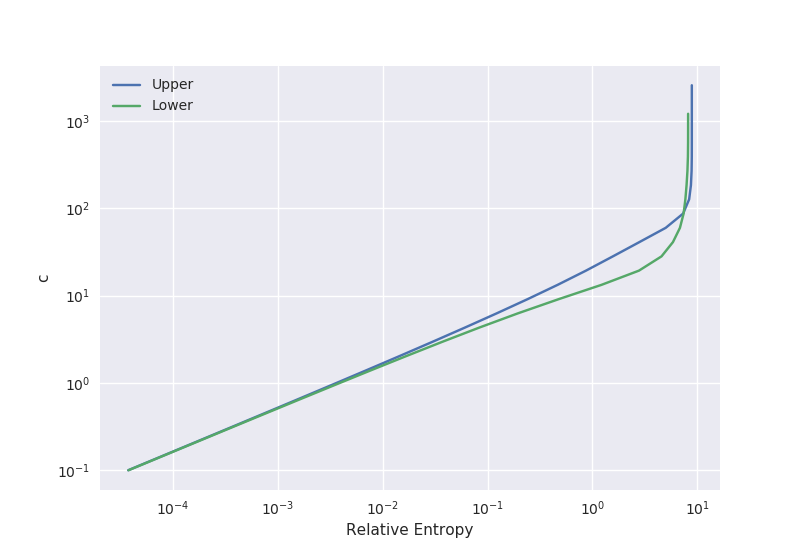

In [13]:
fig = plt.figure()
plt.loglog(Ru,cs,label="Upper")
plt.loglog(Rl,cs,label="Lower")
plt.legend()
plt.xlabel('Relative Entropy')
plt.ylabel('c')
plt.show()

<IPython.core.display.Javascript object>


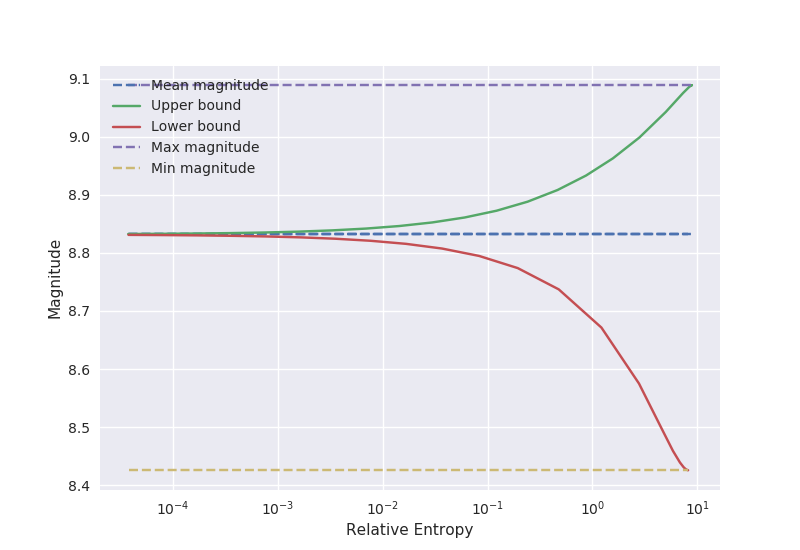

In [14]:
fig = plt.figure()
R = np.concatenate((Rl,Ru))
plt.semilogx(R,EPf*np.ones_like(R),'--',label='Mean '+attr)
plt.semilogx(Ru,ub,label='Upper bound')
plt.semilogx(Rl,lb,label='Lower bound')
plt.semilogx(Ru,f.max()*np.ones(len(Ru)),'--',label='Max '+attr)
plt.semilogx(Rl,f.min()*np.ones(len(Ru)),'--',label='Min '+attr)
plt.legend()
plt.xlabel('Relative Entropy')
plt.ylabel('Magnitude')
plt.show()

<IPython.core.display.Javascript object>


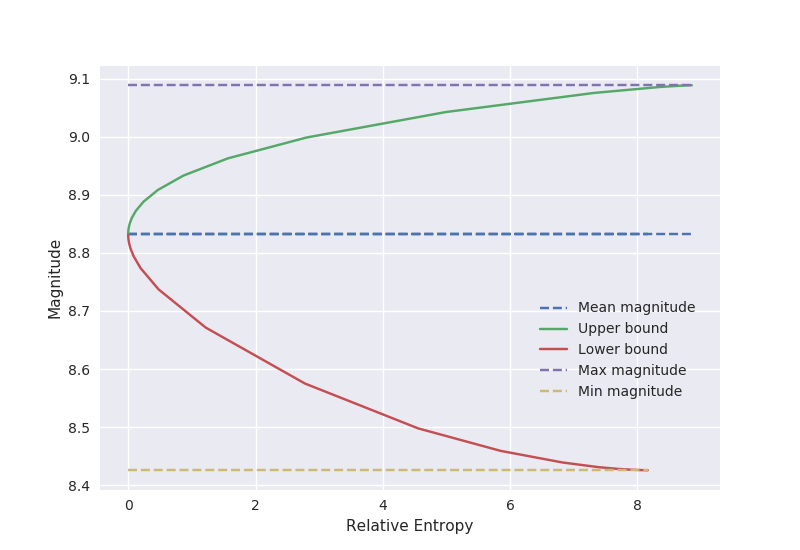

In [15]:
fig = plt.figure()
R = np.concatenate((Rl,Ru))
plt.plot(R,EPf*np.ones_like(R),'--',label='Mean '+attr)
plt.plot(Ru,ub,label='Upper bound')
plt.plot(Rl,lb,label='Lower bound')
plt.plot(Ru,f.max()*np.ones_like(Ru),'--',label='Max '+attr)
plt.plot(Rl,f.min()*np.ones_like(Rl),'--',label='Min '+attr)
plt.legend(loc=(0.7,0.2))
plt.xlabel('Relative Entropy')
plt.ylabel('Magnitude')
plt.show()

### Compare with Hayden's numerical optimization

In [16]:
from scipy.optimize import minimize_scalar

def rel_ent_bound(f,rel_ent):
    EPf = f.mean()
    def ub(c):
        c = c**2
#         print(c)
        expCdelF = np.exp( c*(f-EPf) )
        return (np.log(    expCdelF.mean()) + rel_ent)/c
    def lb(c):
        c = c**2
#         print(c)
#         expCdelF = np.exp( c*(f-EPf) )
#         return -(-np.log((1/expCdelF).mean()) - rel_ent)/c
        expCdelF = np.exp(-c*(f-EPf) )
        return (np.log(    expCdelF.mean()) + rel_ent)/c
    
#     ub_inf = minimize_scalar(ub).fun
#     lb_sup = -minimize_scalar(lb).fun
#     return EPf + lb_sup,EPf + ub_inf    
    ub_opt = minimize_scalar(ub)
    lb_opt = minimize_scalar(lb)
    cu     = ub_opt.x**2
    ub_inf = ub_opt.fun
    cl     = lb_opt.x**2
    lb_sup = -lb_opt.fun
    return EPf + lb_sup,EPf + ub_inf,cl,cu

In [17]:
R = np.logspace(-2,3)
upper  = np.empty_like(R)
lower  = np.empty_like(R)
cupper = np.empty_like(R)
clower = np.empty_like(R)
for i,rel_ent in enumerate(R):
    lower[i],upper[i],clower[i],cupper[i]  = rel_ent_bound(f,rel_ent)

/opt/apps/Anaconda/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/opt/apps/Anaconda/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()
/opt/apps/Anaconda/5.2.0/lib/python3.6/site-packages/scipy/optimize/optimize.py:2308: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/opt/apps/Anaconda/5.2.0/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/apps/Anaconda/5.2.0/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


In [18]:
# fig = plt.figure()
# plt.loglog(cs,Ru,label="Upper (Justin)")
# plt.loglog(cs,Rl,label="Lower (Justin)")
# plt.loglog(cupper,R,'--',label="Upper (Hayden)")
# plt.loglog(clower,R,'--',label="Lower (Hayden)")
# plt.legend()
# plt.xlabel('c')
# plt.ylabel('Relative Entropy')
# plt.show()

<IPython.core.display.Javascript object>


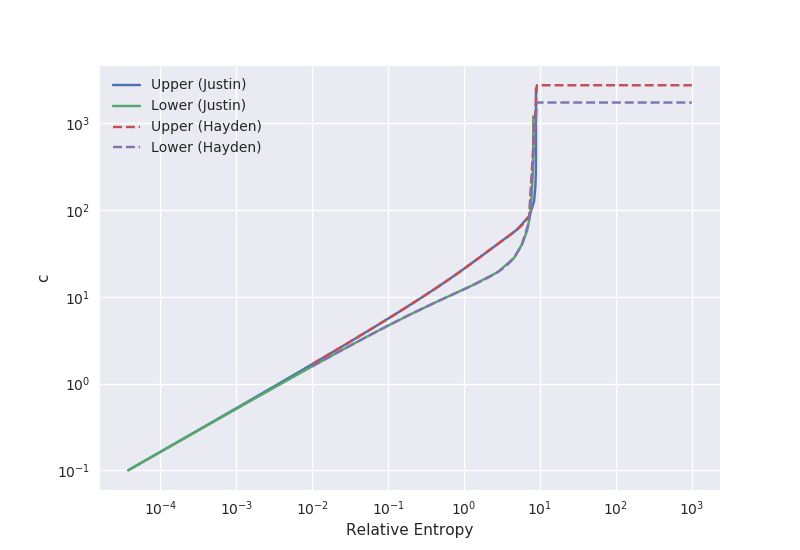

In [19]:
fig = plt.figure()
plt.loglog(Ru,cs,label="Upper (Justin)")
plt.loglog(Rl,cs,label="Lower (Justin)")
plt.loglog(R,cupper,'--',label="Upper (Hayden)")
plt.loglog(R,clower,'--',label="Lower (Hayden)")
plt.legend()
plt.ylabel('c')
plt.xlabel('Relative Entropy')
plt.show()

<IPython.core.display.Javascript object>


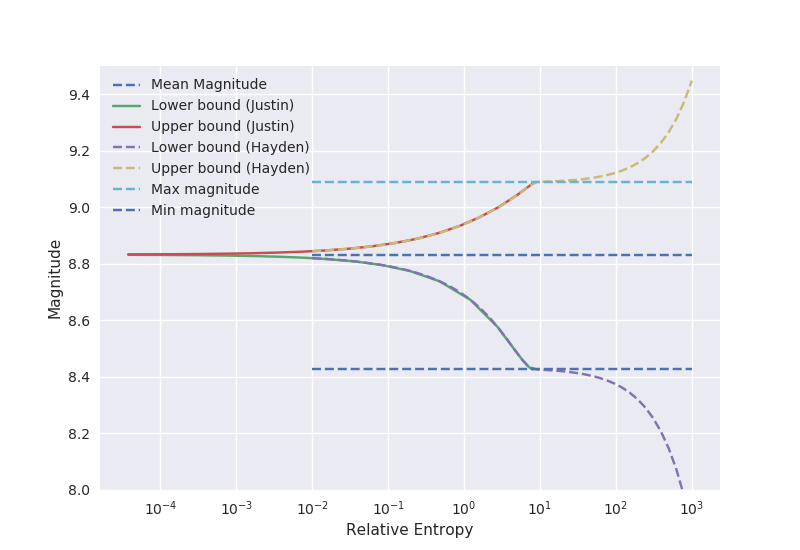

In [20]:
fig = plt.figure()
plt.semilogx(R,EPf*np.ones_like(R),'--',label='Mean Magnitude')
plt.plot(Rl,lb,label='Lower bound (Justin)')
plt.plot(Ru,ub,label='Upper bound (Justin)')
plt.semilogx(R,lower,'--',label='Lower bound (Hayden)')
plt.semilogx(R,upper,'--',label='Upper bound (Hayden)')
plt.semilogx(R,f.max()*np.ones_like(R),'--',label='Max '+attr)
plt.semilogx(R,f.min()*np.ones_like(R),'--',label='Min '+attr)
plt.ylim((8,9.5))
plt.legend()
plt.xlabel('Relative Entropy')
plt.ylabel('Magnitude')
plt.show()

### Plot them all

In [21]:
nthin=1   #optional thinning to reduce computational cost during testing

#list of c's to try
cs = np.logspace(-3,7, num=200)

cols = samples[0].columns
ncol = len(cols)

#preallocate some things
ub  = np.zeros((len(cs),ncol))
lb  = np.zeros((len(cs),ncol))
Ru  = np.zeros((len(cs),ncol))
Rl  = np.zeros((len(cs),ncol))
EPf = np.zeros(ncol)
fmax = np.zeros(ncol)
fmin = np.zeros(ncol)

for j,attr in enumerate(cols):
    f = np.concatenate([ df[attr].values for df in samples ])
    f = f[::nthin]

    #Compute the optimal R for each c using Justin's method

    #precompute some things
    EPf[j] = f.mean() #E_P[f]
    ft  = f-EPf[j]    #deviation from mean

    for i,c in enumerate(cs):
        exppCft = np.exp(  c*ft )  #e^{ c*(f-E_P[f])}
        expmCft = np.exp( -c*ft )  #e^{-c*(f-E_P[f])}
        E1u = exppCft.mean()
        E2u = (ft*exppCft).mean()
        E1l = expmCft.mean()
        E2l = (ft*expmCft).mean()
        #print(i,c,E1u,E2u,E1l,E2l)
        Ru[i,j] =  c*(E2u/E1u) - np.log(E1u)
        Rl[i,j] = -c*(E2l/E1l) - np.log(E1l)
        ub[i,j] = EPf[j] + (E2u/E1u)
        lb[i,j] = EPf[j] + (E2l/E1l)
    
    fmax[j] = f.max()
    fmin[j] = f.min()

/opt/apps/Anaconda/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/opt/apps/Anaconda/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/opt/apps/Anaconda/5.2.0/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/opt/apps/Anaconda/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
/opt/apps/Anaconda/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
/opt/apps/Anaconda/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in multiply
/opt/apps/Anaconda/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in multiply


<IPython.core.display.Javascript object>


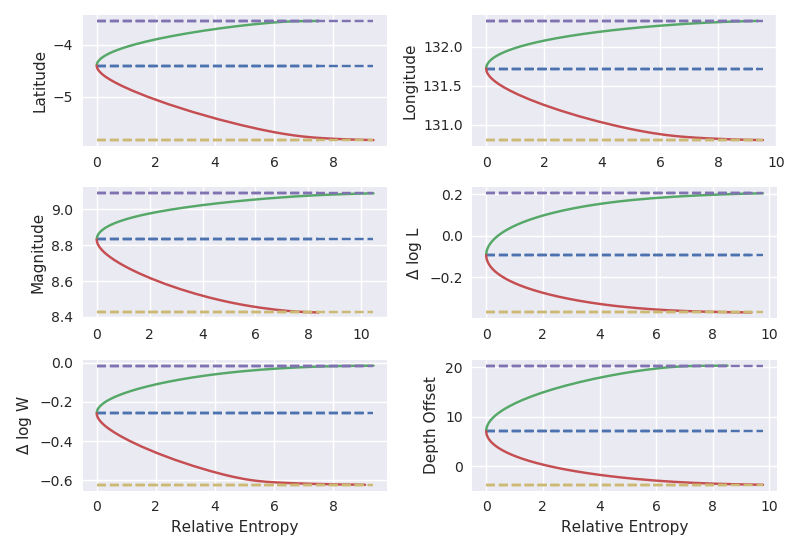

In [22]:
fig,axs = plt.subplots(3,2)
ylabs = [col.title() for col in cols]; ylabs[3]="Delta log L"; ylabs[4]="Delta log W"; ylabs[5]="Depth Offset"; 
for j,ax in enumerate(axs.ravel()):
    attr = ylabs[j]
    R = np.concatenate((Rl[:,j],Ru[:,j]))
    ax.plot(R,EPf[j]*np.ones_like(R),'--',label='Mean')
    ax.plot(Ru[:,j],ub[:,j],label='Upper bound')
    ax.plot(Rl[:,j],lb[:,j],label='Lower bound')
    ax.plot(R,fmax[j]*np.ones_like(R),'--',label='Max')
    ax.plot(R,fmin[j]*np.ones_like(R),'--',label='Min')
    ax.set(ylabel=attr.replace("Delta","$\Delta$"))
    if j>3:
        ax.set(xlabel='Relative Entropy')

plt.tight_layout()
plt.savefig('dupuis211.png')
plt.savefig('dupuis211.pdf')
plt.show()

## Bounds in terms of FIM from Section 2.4

Equation (2.35):
$$
\mathcal{R}\left(P^{\theta+v} || P^{\theta} \right) = \frac{1}{2} v^T \mathcal{I}\left( P^{\theta} \right)v + \mathcal{O}\left( |v|^3 \right)
$$
where the Fisher Information Matrix $\mathcal{I}\left( P^{\theta} \right)$ is given by
$$
\mathcal{I}\left( P^{\theta} \right) = \int \nabla_{\theta} \log p^{\theta}(\omega) \left( \nabla_{\theta} \log p^{\theta}(\omega) \right)^T P^{\theta}(d\omega)
$$

### Normal

FIM for normal with parameterized mean $N(\theta_i,\sigma_i^2)$:
$$
\mathcal{I}_{ii}(P^{(\theta)}) = \frac{1}{\sigma_i^4} \mathbb{V}_{P^{(\theta)}} \left[ \mathcal{G}_i(x) \right]
$$
FIM for normal with parameterized standard deviation $N(m_i,\theta_i^2)$:
$$
\mathcal{I}_{ii}(P^{(\theta)}) = \frac{1}{\theta_i^6} \mathbb{V}_{P^{(\theta)}} \left[ \left(\mathcal{G}_i(x) - m_i\right)^2 \right]
$$

In [23]:
#negative logpdf
def NormalPhi(G,m,sigma):
    return 0.5*(((G-m)/sigma)**2)+np.log(sigma)+0.5*np.log(2*np.pi)

#gradients
def dNormalPhidMean(G,m,sigma):
    return (m-G)/(sigma**2)

def dNormalPhidStd(G,m,sigma):
    return -((G-m)**2)/(sigma**3)+(1/sigma)

#fisher information (variance of gradients)
def fimNormaldMean(G,m,sigma):
    return np.var(G)/(sigma**4)

def fimNormaldStd(G,m,sigma):
    return np.var((G-m)**2)/(sigma**6)

### Skew normal

Derivations for this were a mess - see Overleaf

In [24]:
def SkewnormPhi(G,m,sigma,a):
    #xt = (G-m)/sigma
    #z  = xt*a/np.sqrt(2)
    #phi = 0.5*(xt**2)+np.log(sigma)+0.5*np.log(2*np.pi) \
    #    -np.log(1+scipy.special.erf(z))
    phi = 0.5*(((G-m)/sigma)**2)+np.log(sigma)+0.5*np.log(2*np.pi) \
        -np.log(1+scipy.special.erf(a*(G-m)/(sigma*np.sqrt(2))))
    return phi

def dSkewnormPhidMean(G,m,sigma,a):
    #return (m-G)/(sigma**2)
    xt = (G-m)/sigma
    z  = xt*a/np.sqrt(2)
    return (-xt + np.sqrt(2/np.pi)*a*np.exp(-z**2)/(1+scipy.special.erf(z)))/sigma

def dSkewnormPhidStd(G,m,sigma,a):
    #return -((G-m)**2)/(sigma**3)+(1/sigma)
    xt = (G-m)/sigma
    z  = xt*a/np.sqrt(2)
    return (1-xt**2 + np.sqrt(2/np.pi)*a*xt*np.exp(-z**2)/(1+scipy.special.erf(z)))/sigma
    
def dSkewnormPhidA(G,m,sigma,a):
    #return (m-G)/(sigma**2)
    xt = (G-m)/sigma
    z  = xt*a/np.sqrt(2)
    return -np.sqrt(2/np.pi)*xt*np.exp(-z**2)/(1+scipy.special.erf(z))

def fimSkewnormdMean(G,m,sigma,a):
    return np.var(dSkewnormPhidMean(G,m,sigma,a))

def fimSkewnormdStd(G,m,sigma,a):
    return np.var(dSkewnormPhidStd(G,m,sigma,a))

def fimSkewnormdA(G,m,sigma,a):
    return np.var(dSkewnormPhidA(G,m,sigma,a))

### Chi

When $\theta_i$ is $k$, then
$$
    \mathcal{I}_{ii}(P^{(\theta)}) = \mathbb{V}_{P^{(\theta)}} \left[ \ln \tilde{x} \right]
$$
When $\theta_i$ is $\mu$, then
$$
    \mathcal{I}_{ii}(P^{(\theta)}) = \frac{1}{\sigma^2}\mathbb{V}_{P^{(\theta)}} \left[ \tilde{x} - (k-1)\tilde{x}^{-1} \right]
$$
When $\theta_i$ is $\sigma$, then
$$
    \mathcal{I}_{ii}(P^{(\theta)}) = \frac{1}{\sigma^2}\mathbb{V}_{P^{(\theta)}} \left[ \tilde{x}^2 \right]
$$
where
$$
\tilde{x} = \frac{\mathcal{G}_i(x)-\mu}{\sigma}
$$

In [25]:
#negative logpdf
def ChiPhi(G,mu,sigma,k):
    xt = (G-mu)/sigma
    phi = 0.5*xt**2 + np.log(sigma) + (0.5*k-1)*np.log(2) \
          + np.log(scipy.special.gamma(k/2)) - (k-1)*np.log(xt)
    return phi

#gradients
def dChiPhidK(G,mu,sigma,k):
    xt = (G-mu)/sigma
    return 0.5*np.log(2) + 0.5*scipy.special.digamma(k/2)-np.log(xt)

def dChiPhidMu(G,mu,sigma,k):
    xt = (G-mu)/sigma
    return -(xt-(k-1)/xt)/(sigma)

def dChiPhidSigma(G,mu,sigma,k):
    xt = (G-mu)/sigma
    return -(xt**2-k)/(sigma)

#fisher information (variance of gradients)
def fimChidK(G,mu,sigma,k):
    xt = (G-mu)/sigma
    return np.var(np.log(xt))

def fimChidMu(G,mu,sigma,k):
    xt = (G-mu)/sigma
    return np.var(xt-(k-1)/xt)/(sigma**2)

def fimChidSigma(G,mu,sigma,k):
    xt = (G-mu)/sigma
    return np.var(xt**2)/(sigma**2)

### Test Gradients ###

In [26]:
# Normal

#parameters (from Pulu Ai height)
m=1.8
sigma=0.4

#evaluation point
G = 2.0

#Pulu Ai height
test_dist = stats.norm(loc=m,scale=sigma)

phiScipy = -test_dist.logpdf(G)
phiUs = NormalPhi(G,m,sigma)
print("  Scipy Phi is:",phiScipy)
print("  Our Phi is:  ",phiUs)
print("Error in Phi is:",phiScipy-phiUs)

meps=0.00001
test_dist_meps = stats.norm(loc=(m+meps),scale=sigma)
gradFD = (-test_dist_meps.logpdf(G)+test_dist.logpdf(G))/meps
gradUs = dNormalPhidMean(G,m,sigma)
print("  Finite difference dPhi/dmu is:",gradFD)
print("  Our dPhi/dmu is:              ",gradUs)
print("Error in dPhi/dmu is:",gradFD-gradUs)

seps=0.00001
test_dist_seps = stats.norm(loc=m,scale=(sigma+seps))
gradFD = (-test_dist_seps.logpdf(G)+test_dist.logpdf(G))/seps
gradUs = dNormalPhidStd(G,m,sigma)
print("  Finite difference dPhi/dsigma is:",gradFD)
print("  Our dPhi/dsigma is:              ",gradUs)
print("Error in dPhi/dsigma is:",gradFD-gradUs)

attr = 'Pulu Ai height'
G = np.concatenate([ df[attr].values for df in model_output ])

print("")
print("Error in FIM for theta=mu:   ",np.var(dNormalPhidMean(G,m,sigma))-fimNormaldMean(G,m,sigma))
print("Error in FIM for theta=sigma:",np.var(dNormalPhidStd(G,m,sigma))-fimNormaldStd(G,m,sigma))

  Scipy Phi is: 0.12764780133051767
  Our Phi is:   0.12764780133051756
Error in Phi is: 1.1102230246251565e-16
  Finite difference dPhi/dmu is: -1.2499687500167056
  Our dPhi/dmu is:               -1.2499999999999996
Error in dPhi/dmu is: 3.124998329395723e-05
  Finite difference dPhi/dsigma is: 1.8749921872451834
  Our dPhi/dsigma is:               1.8750000000000004
Error in dPhi/dsigma is: -7.812754817093648e-06

Error in FIM for theta=mu:    -3.552713678800501e-15
Error in FIM for theta=sigma: 0.0


In [27]:
# Skewnorm

#parameters (from Banda Neira arrival)
a=2.0
m=15.0
sigma=5.0

#evaluation point
G = 20.0

#Banda Neira arrival
test_dist = stats.skewnorm(a=a,loc=m,scale=sigma)

phiScipy = -test_dist.logpdf(G)
phiUs = SkewnormPhi(G,m,sigma,a)
print("  Scipy Phi is:",phiScipy)
print("  Our Phi is:  ",phiUs)
print("Error in Phi is:",phiScipy-phiUs)

meps=0.00001
test_dist_meps = stats.skewnorm(a=a,loc=(m+meps),scale=sigma)
gradFD = (-test_dist_meps.logpdf(G)+test_dist.logpdf(G))/meps
gradUs = dSkewnormPhidMean(G,m,sigma,a)
print("  Finite difference dPhi/dmu is:",gradFD)
print("  Our dPhi/dmu is:              ",gradUs)
print("Error in dPhi/dmu is:",gradFD-gradUs)

seps=0.00001
test_dist_seps = stats.skewnorm(a=a,loc=m,scale=(sigma+seps))
gradFD = (-test_dist_seps.logpdf(G)+test_dist.logpdf(G))/seps
gradUs = dSkewnormPhidStd(G,m,sigma,a)
print("  Finite difference dPhi/dsigma is:",gradFD)
print("  Our dPhi/dsigma is:              ",gradUs)
print("Error in dPhi/dsigma is:",gradFD-gradUs)

aeps=0.00001
test_dist_aeps = stats.skewnorm(a=(a+aeps),loc=m,scale=sigma)
gradFD = (-test_dist_aeps.logpdf(G)+test_dist.logpdf(G))/aeps
gradUs = dSkewnormPhidA(G,m,sigma,a)
print("  Finite difference dPhi/da is:",gradFD)
print("  Our dPhi/da is:              ",gradUs)
print("Error in dPhi/da is:",gradFD-gradUs)

attr = 'Pulu Ai height'
G = np.concatenate([ df[attr].values for df in model_output ])

print("")
print("Error in FIM for theta=mu:   ",np.var(dSkewnormPhidMean(G,m,sigma,a))-fimSkewnormdMean(G,m,sigma,a))
print("Error in FIM for theta=sigma:",np.var(dSkewnormPhidStd(G,m,sigma,a))-fimSkewnormdStd(G,m,sigma,a))
print("Error in FIM for theta=a:    ",np.var(dSkewnormPhidA(G,m,sigma,a))-fimSkewnormdA(G,m,sigma,a))

  Scipy Phi is: 2.358242174407791
  Our Phi is:   2.3582421744077915
Error in Phi is: -4.440892098500626e-16
  Finite difference dPhi/dmu is: -0.17790056405786456
  Our dPhi/dmu is:               -0.177900854928404
Error in dPhi/dmu is: 2.9087053943221974e-07
  Finite difference dPhi/dsigma is: 0.02209959175658582
  Our dPhi/dsigma is:               0.022099145071595997
Error in dPhi/dsigma is: 4.4668498982297633e-07
  Finite difference dPhi/da is: -0.05524729491668267
  Our dPhi/da is:               -0.05524786267898999
Error in dPhi/da is: 5.677623073213622e-07

Error in FIM for theta=mu:    0.0
Error in FIM for theta=sigma: 0.0
Error in FIM for theta=a:     0.0


In [28]:
# Chi

#parameters (from Buru height)
k=1.01
m=0.5
sigma=1.5

#evaluation point
G = 2.0

#Buru height
buru_height = stats.chi(df=k,loc=m,scale=sigma) #dists[3]['height']

print("Error in Phi is:",-buru_height.logpdf(G)-ChiPhi(G,m,sigma,k))

keps=0.0001
buru_height_keps = stats.chi(df=(k+keps),loc=m,scale=sigma)
gradFD = (-buru_height_keps.logpdf(G)+buru_height.logpdf(G))/keps
gradUs = dChiPhidK(G,m,sigma,k)
print("  Finite difference dPhi/dK is:",gradFD)
print("  Our dPhi/dK is:              ",gradUs)
print("Error in dPhi/dK is:",gradFD-gradUs)

meps=0.0001
buru_height_meps = stats.chi(df=k,loc=(m+meps),scale=sigma)
gradFD = (-buru_height_meps.logpdf(G)+buru_height.logpdf(G))/meps
gradUs = dChiPhidMu(G,m,sigma,k)
print("  Finite difference dPhi/dmu is:",gradFD)
print("  Our dPhi/dmu is:              ",gradUs)
print("Error in dPhi/dmu is:",gradFD-gradUs)

seps=0.00001
buru_height_seps = stats.chi(df=k,loc=m,scale=(sigma+seps))
gradFD = (-buru_height_seps.logpdf(G)+buru_height.logpdf(G))/seps
gradUs = dChiPhidSigma(G,m,sigma,k)
print("  Finite difference dPhi/dsigma is:",gradFD)
print("  Our dPhi/dsigma is:              ",gradUs)
print("Error in dPhi/dsigma is:",gradFD-gradUs)

attr = 'Buru height'
G = np.concatenate([ df[attr].values for df in model_output ])

print("")
print("Error in FIM for theta=k:    ",np.var(dChiPhidK(G,m,sigma,k))-fimChidK(G,m,sigma,k))
print("Error in FIM for theta=mu:   ",np.var(dChiPhidMu(G,m,sigma,k))-fimChidMu(G,m,sigma,k))
print("Error in FIM for theta=sigma:",np.var(dChiPhidSigma(G,m,sigma,k))-fimChidSigma(G,m,sigma,k))

Error in Phi is: 0.0
  Finite difference dPhi/dK is: -0.6228879476322113
  Our dPhi/dK is:               -0.6229485924764557
Error in dPhi/dK is: 6.06448442443952e-05
  Finite difference dPhi/dmu is: -0.6599775555438114
  Our dPhi/dmu is:               -0.66
Error in dPhi/dmu is: 2.244445618859725e-05
  Finite difference dPhi/dsigma is: 0.006671088836895932
  Our dPhi/dsigma is:               0.006666666666666672
Error in dPhi/dsigma is: 4.422170229259961e-06

Error in FIM for theta=k:     2.7755575615628914e-17
Error in FIM for theta=mu:    -3.469446951953614e-18
Error in FIM for theta=sigma: -1.3877787807814457e-17


### Compute

In [29]:
model_output[0].head()

,Pulu Ai height,Ambon height,Banda Neira arrival,Banda Neira height,Banda Neira inundation,Buru height,Hulaliu height,Saparua arrival,Saparua height,Saparua inundation,Kulur height,Ameth height,Amahai height
0,2.699779,2.08873,10.661705,4.845863,136.294774,0.746908,0.875773,37.84129,3.772082,97.845866,0.666697,1.037849,2.368544
1,2.699779,2.08873,10.661705,4.845863,136.294774,0.746908,0.875773,37.84129,3.772082,97.845866,0.666697,1.037849,2.368544
2,2.699779,2.08873,10.661705,4.845863,136.294774,0.746908,0.875773,37.84129,3.772082,97.845866,0.666697,1.037849,2.368544
3,2.699779,2.08873,10.661705,4.845863,136.294774,0.746908,0.875773,37.84129,3.772082,97.845866,0.666697,1.037849,2.368544
4,2.699779,2.08873,10.661705,4.845863,136.294774,0.746908,0.875773,37.84129,3.772082,97.845866,0.666697,1.037849,2.368544


In [30]:
#Define distributions

dists = []

# Pulu Ai
dist = dict()
dist['name'] = 'Pulu Ai'
dist['height'] = stats.norm(loc=3,scale=0.8)
dists.append(dist)

# Ambon
dist = dict()
dist['name'] = 'Ambon'
dist['height'] = stats.norm(loc=1.8,scale=0.4)
dists.append(dist)

# Banda Neira
dist = dict()
dist['name'] = 'Banda Neira'
dist['arrival'] = stats.skewnorm(a=2,loc=15,scale=5)
dist['height'] = stats.norm(loc=6.5,scale=1.5)
dist['inundation'] = stats.norm(loc=185,scale=65)
dists.append(dist)

# Buru
dist = dict()
dist['name'] = 'Buru'
dist['height'] = stats.chi(df=1.01,loc=0.5,scale=1.5)
dists.append(dist)

# Hulaliu
dist = dict()
dist['name'] = 'Hulaliu'
dist['height'] = stats.chi(df=1.01,loc=0.5,scale=2.0)
dists.append(dist)

# Saparua
dist = dict()
dist['name'] = 'Saparua'
dist['arrival'] = stats.norm(loc=45,scale=5)
dist['height'] = stats.norm(loc=5,scale=1)
dist['inundation'] = stats.norm(loc=125,scale=40)
dists.append(dist)

# Kulur
dist = dict()
dist['name'] = 'Kulur'
dist['height'] = stats.norm(loc=3,scale=1)
dists.append(dist)

# Ameth
dist = dict()
dist['name'] = 'Ameth'
dist['height'] = stats.norm(loc=3,scale=1)
dists.append(dist)

# Amahai
dist = dict()
dist['name'] = 'Amahai'
dist['height'] = stats.norm(loc=3.5,scale=1)
dists.append(dist)

In [31]:
# nthin = 10

# FIM = []
# for location in dists:
#     for key in ['arrival','height','inundation']:
#         if key in location:
#             dist=location[key]
#             attr=location['name']+' '+key
#             G = np.concatenate([ df[attr].values for df in model_output ])
#             G = G[::nthin]


#             #print('Processing',attr)
#             if isinstance(dist.dist, stats._continuous_distns.norm_gen):
#                 m = dist.__dict__['kwds']['loc'] #dist.mean()
#                 sigma = dist.__dict__['kwds']['scale'] #dist.std()
#                 print('Found normal at',attr,'with mean',m,'and std',sigma)
#                 dNdm = dNormaldMean(G,m,sigma)
#                 dNds = dNormaldStd(G,m,sigma)
#                 FIM.append(dNdm)
#                 FIM.append(dNds)
#                 print('dNdm =',dNdm,', dNds =',dNds)
#                 #print('Length of FIM:',len(FIM))
#             elif isinstance(dist.dist, stats._continuous_distns.skew_norm_gen):
#                 m = dist.__dict__['kwds']['loc']
#                 sigma = dist.__dict__['kwds']['scale']
#                 a = dist.__dict__['kwds']['a']
#                 print('Found skew normal at',attr,'with m',m,'and sigma',sigma,'and a',a)
#                 dSNdm = dSkewnormdMean(G,m,sigma,a)
#                 dSNds = dSkewnormdStd(G,m,sigma,a)
#                 FIM.append(dSNdm)
#                 FIM.append(dSNds)
#                 print('dSNdm =',dNdm,', dSNds =',dNds, ', dSNda = TBD ;-)')
#             elif isinstance(dist.dist, stats._continuous_distns.chi_gen):
#                 m = dist.__dict__['kwds']['loc']
#                 sigma = dist.__dict__['kwds']['scale']
#                 dof = dist.__dict__['kwds']['df']
#                 print('Found skew normal at',attr,'with m',m,'and sigma',sigma,'and dof',dof)
#             else:
#                 print('ERROR: Distribution for',attr,'not found')

In [32]:
#this computes the diagonal components
nthin = 1 #optional thinning of model outputs

FIM = pd.DataFrame(columns = ['Name', 'Observation', 'Distribution', 'Parameter', 'Fisher Information'])
for location in dists:
    for key in ['arrival','height','inundation']:
        if key in location:
            dist=location[key]
            attr=location['name']+' '+key
            G = np.concatenate([ df[attr].values for df in model_output ])
            G = G[::nthin]

            #normal distribution
            if isinstance(dist.dist, stats._continuous_distns.norm_gen):
                m = dist.__dict__['kwds']['loc'] #dist.mean()
                sigma = dist.__dict__['kwds']['scale'] #dist.std()
                #print('Found normal at',attr,'with mean',m,'and std',sigma)
                fimm = fimNormaldMean(G,m,sigma)
                fims = fimNormaldStd(G,m,sigma)
                #print('dNdm =',dNdm,', dNds =',dNds)
                FIM = FIM.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'normal', 
                    'Parameter' : 'mean', 'Fisher Information' : fimm }, 
                    ignore_index = True)
                FIM = FIM.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'normal', 
                    'Parameter' : 'std', 'Fisher Information' : fims }, 
                    ignore_index = True)
            
            #skewnorm distribution
            elif isinstance(dist.dist, stats._continuous_distns.skew_norm_gen):
                m = dist.__dict__['kwds']['loc']
                sigma = dist.__dict__['kwds']['scale']
                a = dist.__dict__['kwds']['a']
                #print('Found skew normal at',attr,'with m',m,'and sigma',sigma,'and a',a)
                fimm = fimSkewnormdMean(G,m,sigma,a)
                fims = fimSkewnormdStd(G,m,sigma,a)
                fima = fimSkewnormdA(G,m,sigma,a)
                #print('dSNdm =',dNdm,', dSNds =',dNds, ', dSNda = TBD ;-)')
                FIM = FIM.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'skewnorm', 
                    'Parameter' : 'mean', 'Fisher Information' : fimm }, 
                    ignore_index = True)
                FIM = FIM.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'skewnorm', 
                    'Parameter' : 'std', 'Fisher Information' : fims }, 
                    ignore_index = True)
                FIM = FIM.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'skewnorm', 
                    'Parameter' : 'a', 'Fisher Information' : fima }, 
                    ignore_index = True)
            
            #chi distribution
            elif isinstance(dist.dist, stats._continuous_distns.chi_gen):
                mu = dist.__dict__['kwds']['loc']
                sigma = dist.__dict__['kwds']['scale']
                dof = dist.__dict__['kwds']['df']
                #print('Found chi at',attr,'with m',m,'and sigma',sigma,'and dof',dof)
                fimm = fimChidMu(G,mu,sigma,dof)
                fims = fimChidSigma(G,mu,sigma,dof)
                fimk = fimChidK(G,mu,sigma,dof)
                #print('dChidm =',dChidm,', dChids =',dChids, ', dChidk =',dChidk)
                FIM = FIM.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'chi', 
                    'Parameter' : 'mu', 'Fisher Information' : fimm }, 
                    ignore_index = True)
                FIM = FIM.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'chi', 
                    'Parameter' : 'sigma', 'Fisher Information' : fims }, 
                    ignore_index = True)
                FIM = FIM.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'chi', 
                    'Parameter' : 'dof', 'Fisher Information' : fimk }, 
                    ignore_index = True)
            #other
            else:
                print('ERROR: Distribution for',attr,'not found')

FIM

,Name,Observation,Distribution,Parameter,Fisher Information
0,Pulu Ai,height,normal,mean,0.659360
1,Pulu Ai,height,normal,std,3.913890
2,Ambon,height,normal,mean,3.817967
3,Ambon,height,normal,std,32.626215
4,Banda Neira,arrival,skewnorm,mean,0.062585
5,Banda Neira,arrival,skewnorm,std,0.077995
6,Banda Neira,arrival,skewnorm,a,0.334808
7,Banda Neira,height,normal,mean,0.178098
8,Banda Neira,height,normal,std,0.392700
9,Banda Neira,inundation,normal,mean,0.000078


In [33]:
#Compute sensitivity bounds from equation (2.39)

nthin = 1 #optional thinning of sample data

sensDF = FIM.copy()

cols = samples[0].columns
ncol = len(cols)

for j,attr in enumerate(cols):
    f = np.concatenate([ df[attr].values for df in samples ])
    f = f[::nthin]
    fvar = np.var(f)
    print('Variance for',attr,'is:',fvar)
    
    #Equation (2.39)
    sensDF['S_'+attr] = np.sqrt(fvar*sensDF['Fisher Information'])

sensDF

Variance for latitude is: 0.06612089778644199
Variance for longitude is: 0.040124123692999156
Variance for magnitude is: 0.007577022591804167
Variance for delta_logl is: 0.010526227689505006
Variance for delta_logw is: 0.006174954661870555
Variance for depth_offset is: 14.482727059630047


,Name,Observation,Distribution,Parameter,Fisher Information,S_latitude,S_longitude,S_magnitude,S_delta_logl,S_delta_logw,S_depth_offset
0,Pulu Ai,height,normal,mean,0.659360,0.208800,0.162654,0.070682,0.083310,0.063808,3.090199
1,Pulu Ai,height,normal,std,3.913890,0.508714,0.396285,0.172208,0.202974,0.155461,7.528865
2,Ambon,height,normal,mean,3.817967,0.502441,0.391398,0.170085,0.200471,0.153544,7.436032
3,Ambon,height,normal,std,32.626215,1.468766,1.144158,0.497202,0.586030,0.448849,21.737446
4,Banda Neira,arrival,skewnorm,mean,0.062585,0.064329,0.050111,0.021776,0.025667,0.019659,0.952050
5,Banda Neira,arrival,skewnorm,std,0.077995,0.071813,0.055942,0.024310,0.028653,0.021946,1.062819
6,Banda Neira,arrival,skewnorm,a,0.334808,0.148788,0.115905,0.050367,0.059366,0.045469,2.202029
7,Banda Neira,height,normal,mean,0.178098,0.108517,0.084534,0.036735,0.043298,0.033162,1.606035
8,Banda Neira,height,normal,std,0.392700,0.161139,0.125526,0.054548,0.064293,0.049243,2.384820
9,Banda Neira,inundation,normal,mean,0.000078,0.002268,0.001767,0.000768,0.000905,0.000693,0.033571


In [34]:
print(sensDF.to_latex(index=False,formatters={
    'Fisher Information' : '{:.1e}'.format,
    'S_latitude'         : '{:.3f}'.format,
    'S_longitude'        : '{:.3f}'.format,
    'S_magnitude'        : '{:.3f}'.format,
    'S_delta_logl'       : '{:.3f}'.format,
    'S_delta_logw'       : '{:.3f}'.format,
    'S_depth_offset'     : '{:.3f}'.format,
    }))

\begin{tabular}{llllrrrrrrr}
\toprule
        Name & Observation & Distribution & Parameter & Fisher Information & S\_latitude & S\_longitude & S\_magnitude & S\_delta\_logl & S\_delta\_logw & S\_depth\_offset \\
\midrule
     Pulu Ai &      height &       normal &      mean &            6.6e-01 &      0.209 &       0.163 &       0.071 &        0.083 &        0.064 &          3.090 \\
     Pulu Ai &      height &       normal &       std &            3.9e+00 &      0.509 &       0.396 &       0.172 &        0.203 &        0.155 &          7.529 \\
       Ambon &      height &       normal &      mean &            3.8e+00 &      0.502 &       0.391 &       0.170 &        0.200 &        0.154 &          7.436 \\
       Ambon &      height &       normal &       std &            3.3e+01 &      1.469 &       1.144 &       0.497 &        0.586 &        0.449 &         21.737 \\
 Banda Neira &     arrival &     skewnorm &      mean &            6.3e-02 &      0.064 &       0.050 &       0.02

In [35]:
#compute the derivatives for each distribution parameter
nthin = 1 #optional thinning of model outputs

derivs = pd.DataFrame(columns = ['Name', 'Observation', 'Distribution', 'Parameter', 'Value', 'Derivative'])
for location in dists:
    for key in ['arrival','height','inundation']:
        if key in location:
            dist=location[key]
            attr=location['name']+' '+key
            G = np.concatenate([ df[attr].values for df in model_output ])
            G = G[::nthin]

            #normal distribution
            if isinstance(dist.dist, stats._continuous_distns.norm_gen):
                m = dist.__dict__['kwds']['loc'] #dist.mean()
                sigma = dist.__dict__['kwds']['scale'] #dist.std()
                #print('Found normal at',attr,'with mean',m,'and std',sigma)
                dm = dNormalPhidMean(G,m,sigma)
                ds = dNormalPhidStd(G,m,sigma)
                #print('dNdm =',dm,', dNds =',ds)
                derivs = derivs.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'normal', 
                    'Parameter' : 'mean', 'Value' : m, 'Derivative' : dm }, 
                    ignore_index = True)
                derivs = derivs.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'normal', 
                    'Parameter' : 'std', 'Value' : sigma, 'Derivative' : ds }, 
                    ignore_index = True)
            
            #skewnorm distribution
            elif isinstance(dist.dist, stats._continuous_distns.skew_norm_gen):
                m = dist.__dict__['kwds']['loc']
                sigma = dist.__dict__['kwds']['scale']
                a = dist.__dict__['kwds']['a']
                #print('Found skew normal at',attr,'with m',m,'and sigma',sigma,'and a',a)
                dm = dSkewnormPhidMean(G,m,sigma,a)
                ds = dSkewnormPhidStd(G,m,sigma,a)
                da = dSkewnormPhidA(G,m,sigma,a)
                #print('dSNdm =',dm,', dSNds =',ds, ', dSNda =',da)
                derivs = derivs.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'skewnorm', 
                    'Parameter' : 'mean', 'Value' : m, 'Derivative' : dm }, 
                    ignore_index = True)
                derivs = derivs.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'skewnorm', 
                    'Parameter' : 'std', 'Value' : sigma, 'Derivative' : ds }, 
                    ignore_index = True)
                derivs = derivs.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'skewnorm', 
                    'Parameter' : 'a', 'Value' : a, 'Derivative' : da }, 
                    ignore_index = True)

            #chi distribution
            elif isinstance(dist.dist, stats._continuous_distns.chi_gen):
                mu = dist.__dict__['kwds']['loc']
                sigma = dist.__dict__['kwds']['scale']
                dof = dist.__dict__['kwds']['df']
                #print('Found chi at',attr,'with m',m,'and sigma',sigma,'and dof',dof)
                dm = dChiPhidMu(G,mu,sigma,dof)
                ds = dChiPhidSigma(G,mu,sigma,dof)
                dk = dChiPhidK(G,mu,sigma,dof)
                #print('dChidm =',dm,', dChids =',ds, ', dChidk =',dk)
                derivs = derivs.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'chi', 
                    'Parameter' : 'mu', 'Value' : mu, 'Derivative' : dm }, 
                    ignore_index = True)
                derivs = derivs.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'chi', 
                    'Parameter' : 'sigma', 'Value' : sigma, 'Derivative' : ds }, 
                    ignore_index = True)
                derivs = derivs.append({
                    'Name' : location['name'], 'Observation' : key, 'Distribution' : 'chi', 
                    'Parameter' : 'dof', 'Value' : dof, 'Derivative' : dk }, 
                    ignore_index = True)

            else:
                print('ERROR: Distribution for',attr,'not found')

derivs

,Name,Observation,Distribution,Parameter,Value,Derivative
0,Pulu Ai,height,normal,mean,3,"[0.4690953125000007, 0.4690953125000007, 0.469..."
1,Pulu Ai,height,normal,std,0.8,"[1.0739596702324212, 1.0739596702324212, 1.073..."
2,Ambon,height,normal,mean,1.8,"[-1.8045624999999854, -1.8045624999999854, -1...."
3,Ambon,height,normal,std,0.4,"[1.197421673437521, 1.197421673437521, 1.19742..."
4,Banda Neira,arrival,skewnorm,mean,15,"[1.0299270590454817, 1.0299270590454817, 1.029..."
5,Banda Neira,arrival,skewnorm,std,5,"[-0.6936254134625395, -0.6936254134625395, -0...."
6,Banda Neira,arrival,skewnorm,a,2,"[1.85764752135978, 1.85764752135978, 1.8576475..."
7,Banda Neira,height,normal,mean,6.5,"[0.7351719999999994, 0.7351719999999994, 0.735..."
8,Banda Neira,height,normal,std,1.5,"[-0.14405013770933195, -0.14405013770933195, -..."
9,Banda Neira,inundation,normal,mean,185,"[0.011527864145281086, 0.011527864145281086, 0..."


In [36]:
#get the full FIM
dMat = np.vstack(derivs['Derivative'])
fimFullAbs = np.cov(dMat)
fimDiagAbs = np.diagonal(fimFullAbs)
derivs['FI'] = fimDiagAbs
fimDiagAbs

array([6.59369203e-01, 3.91394629e+00, 3.81802130e+00, 3.26266812e+01,
       6.25857000e-02, 7.79964206e-02, 3.34812703e-01, 1.78100783e-01,
       3.92705586e-01, 7.78189802e-05, 6.44880262e-05, 2.58820636e-02,
       5.43864019e-02, 1.39643054e-01, 4.01233759e-03, 7.89737868e-04,
       1.81014975e-01, 9.51324319e-03, 5.11965493e-02, 3.63394367e-01,
       8.69211318e-01, 1.85894348e-04, 1.11148122e-04, 2.21620891e-02,
       3.62166602e-01, 3.89676724e-02, 4.08669279e-01, 3.35250213e-01,
       7.84058142e-01])

In [37]:
#Convert FIM from absolute changes to relative changes
vals=np.array(derivs['Value'],dtype=float)
fimFull = np.diag(vals) @ fimFullAbs @ np.diag(vals)
fimDiag = np.diagonal(fimFull)

In [38]:
#size of perturbation for RE=1
derivs['FI Rel'] = fimDiag
derivs['Perturbation'] = np.sqrt(2/fimDiag)
#derivs['Rel Perturbation'] = derivs['Perturbation']/derivs['Value']
derivs['R 0.1'] = 0.5*fimDiag*(0.1**2)

#check that scaled FIM and absolute FIM produce the same RE=1 perturbations
print("norm difference between RE=1 relative perturbations computed with the absolute FIM and relative FIM is:", \
      np.linalg.norm( derivs['Perturbation'] - np.sqrt(2/fimDiagAbs)/vals ) )

derivs.loc[:, derivs.columns != 'Derivative']

norm difference between RE=1 relative perturbations computed with the absolute FIM and relative FIM is: 2.7755575615628914e-16


,Name,Observation,Distribution,Parameter,Value,FI,FI Rel,Perturbation,R 0.1
0,Pulu Ai,height,normal,mean,3,0.659369,5.934323,0.580536,0.029672
1,Pulu Ai,height,normal,std,0.8,3.913946,2.504926,0.893547,0.012525
2,Ambon,height,normal,mean,1.8,3.818021,12.370389,0.402090,0.061852
3,Ambon,height,normal,std,0.4,32.626681,5.220269,0.618969,0.026101
4,Banda Neira,arrival,skewnorm,mean,15,0.062586,14.081782,0.376865,0.070409
5,Banda Neira,arrival,skewnorm,std,5,0.077996,1.949911,1.012763,0.009750
6,Banda Neira,arrival,skewnorm,a,2,0.334813,1.339251,1.222036,0.006696
7,Banda Neira,height,normal,mean,6.5,0.178101,7.524758,0.515548,0.037624
8,Banda Neira,height,normal,std,1.5,0.392706,0.883588,1.504493,0.004418
9,Banda Neira,inundation,normal,mean,185,0.000078,2.663355,0.866564,0.013317


In [39]:
print(derivs.drop(['Derivative','FI'],axis=1).to_latex(index=False,formatters={
    'FI Rel' : '{:.3f}'.format,
    'Perturbation'          : '{:.3f}'.format,
    }))

\begin{tabular}{lllllrrr}
\toprule
        Name & Observation & Distribution & Parameter & Value & FI Rel & Perturbation &     R 0.1 \\
\midrule
     Pulu Ai &      height &       normal &      mean &     3 &  5.934 &        0.581 &  0.029672 \\
     Pulu Ai &      height &       normal &       std &   0.8 &  2.505 &        0.894 &  0.012525 \\
       Ambon &      height &       normal &      mean &   1.8 & 12.370 &        0.402 &  0.061852 \\
       Ambon &      height &       normal &       std &   0.4 &  5.220 &        0.619 &  0.026101 \\
 Banda Neira &     arrival &     skewnorm &      mean &    15 & 14.082 &        0.377 &  0.070409 \\
 Banda Neira &     arrival &     skewnorm &       std &     5 &  1.950 &        1.013 &  0.009750 \\
 Banda Neira &     arrival &     skewnorm &         a &     2 &  1.339 &        1.222 &  0.006696 \\
 Banda Neira &      height &       normal &      mean &   6.5 &  7.525 &        0.516 &  0.037624 \\
 Banda Neira &      height &       normal &    

In [40]:
#svd
u, s, vh = np.linalg.svd(fimFull)
#checks
print("||u-v||             =",np.linalg.norm(u-vh.T))
print("||M*u_1 - s_1 u_1|| =",np.linalg.norm(np.matmul(fimFull,u[:,0]) - s[0]*u[:,0]))
#print s
print("singular values:")
display(s)
print("leading singular vector:")
display(u[:,0])

||u-v||             = 2.1262139151803494e-09
||M*u_1 - s_1 u_1|| = 1.3632070606330227e-14
singular values:


array([2.75402776e+01, 2.07615892e+01, 1.43162870e+01, 1.31747067e+01,
       9.05934227e+00, 4.40567727e+00, 2.96989335e+00, 5.84773540e-01,
       5.11468562e-01, 4.18083123e-01, 3.72539737e-01, 3.12527341e-01,
       1.92712294e-01, 1.25891478e-01, 9.74146674e-02, 5.88809118e-02,
       4.65000613e-02, 2.61412109e-02, 1.04901162e-02, 9.13252657e-03,
       1.16258134e-03, 8.82563534e-04, 6.62301173e-04, 4.77181265e-04,
       1.48383989e-04, 6.21913937e-05, 8.26000148e-06, 9.08530961e-08,
       4.50681382e-08])

leading singular vector:


array([-1.51253117e-01,  8.66671015e-02,  3.64273384e-01,  2.15591801e-01,
        4.47233412e-01, -1.48076428e-01,  1.32277661e-01, -1.41696593e-02,
       -6.22562609e-03, -9.68471367e-03, -5.80820428e-03,  8.50967845e-03,
        3.45481120e-02,  4.02407452e-02,  2.59938813e-05, -4.37381177e-04,
        1.53783084e-03,  7.16224440e-01, -1.62780102e-01,  8.66988789e-03,
       -5.28119623e-03,  4.56837460e-03, -2.84203103e-03,  3.76853342e-02,
       -5.04644940e-02,  4.27715478e-02, -4.62798135e-02,  1.39340766e-02,
       -8.21112288e-04])

<IPython.core.display.Javascript object>


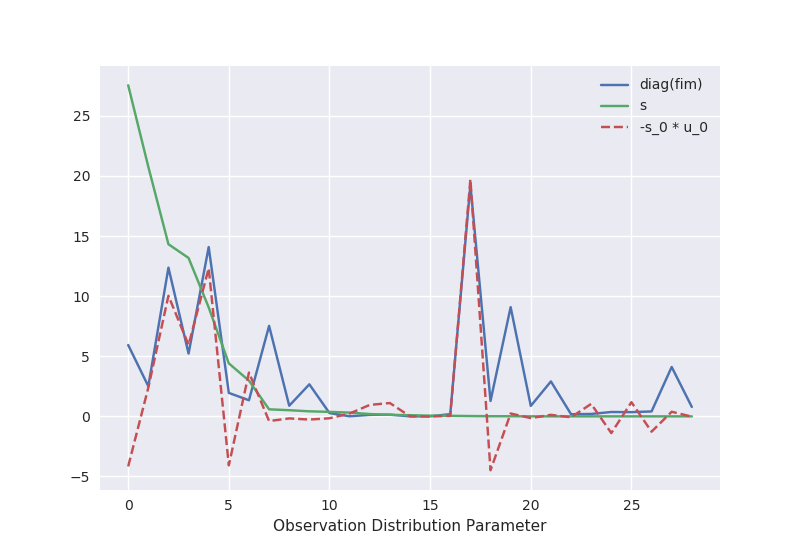

In [41]:
fig = plt.figure()
plt.plot(np.diagonal(fimFull),label="diag(fim)")
plt.plot(s,label="s")
plt.plot(u[:,0]*s[0],"--",label="-s_0 * u_0")
plt.legend()
plt.xlabel('Observation Distribution Parameter')
#plt.ylabel('Magnitude')
plt.show()

In [42]:
derivs['Sing Vec'] = u[:,0]
derivs_print = derivs.drop(['Derivative','FI','Perturbation'],axis=1)
print(derivs_print.to_latex(index=False,formatters={
    'FI Rel'   : '{:.3f}'.format,
    'R 0.1'    : '{:.3f}'.format,
    'Sing Vec' : '{:.3f}'.format,
    }))
derivs_print

\begin{tabular}{lllllrrr}
\toprule
        Name & Observation & Distribution & Parameter & Value & FI Rel & R 0.1 & Sing Vec \\
\midrule
     Pulu Ai &      height &       normal &      mean &     3 &  5.934 & 0.030 &   -0.151 \\
     Pulu Ai &      height &       normal &       std &   0.8 &  2.505 & 0.013 &    0.087 \\
       Ambon &      height &       normal &      mean &   1.8 & 12.370 & 0.062 &    0.364 \\
       Ambon &      height &       normal &       std &   0.4 &  5.220 & 0.026 &    0.216 \\
 Banda Neira &     arrival &     skewnorm &      mean &    15 & 14.082 & 0.070 &    0.447 \\
 Banda Neira &     arrival &     skewnorm &       std &     5 &  1.950 & 0.010 &   -0.148 \\
 Banda Neira &     arrival &     skewnorm &         a &     2 &  1.339 & 0.007 &    0.132 \\
 Banda Neira &      height &       normal &      mean &   6.5 &  7.525 & 0.038 &   -0.014 \\
 Banda Neira &      height &       normal &       std &   1.5 &  0.884 & 0.004 &   -0.006 \\
 Banda Neira &  inundation

,Name,Observation,Distribution,Parameter,Value,FI Rel,R 0.1,Sing Vec
0,Pulu Ai,height,normal,mean,3,5.934323,0.029672,-0.151253
1,Pulu Ai,height,normal,std,0.8,2.504926,0.012525,0.086667
2,Ambon,height,normal,mean,1.8,12.370389,0.061852,0.364273
3,Ambon,height,normal,std,0.4,5.220269,0.026101,0.215592
4,Banda Neira,arrival,skewnorm,mean,15,14.081782,0.070409,0.447233
5,Banda Neira,arrival,skewnorm,std,5,1.949911,0.009750,-0.148076
6,Banda Neira,arrival,skewnorm,a,2,1.339251,0.006696,0.132278
7,Banda Neira,height,normal,mean,6.5,7.524758,0.037624,-0.014170
8,Banda Neira,height,normal,std,1.5,0.883588,0.004418,-0.006226
9,Banda Neira,inundation,normal,mean,185,2.663355,0.013317,-0.009685


\begin{tabular}{lrr}
\toprule
      Parameter & Variance & Sensitivity \\
\midrule
       Latitude &    0.066 &       0.135 \\
      Longitude &    0.040 &       0.105 \\
      Magnitude &    0.008 &       0.046 \\
 $\Delta$ log L &    0.011 &       0.054 \\
 $\Delta$ log W &    0.006 &       0.041 \\
   Depth Offset &   14.483 &       1.997 \\
\bottomrule
\end{tabular}



,Parameter,Variance,Sensitivity
0,Latitude,0.066121,0.134944
1,Longitude,0.040124,0.105120
2,Magnitude,0.007577,0.045681
3,$\Delta$ log L,0.010526,0.053842
4,$\Delta$ log W,0.006175,0.041238
5,Depth Offset,14.482727,1.997144


<IPython.core.display.Javascript object>


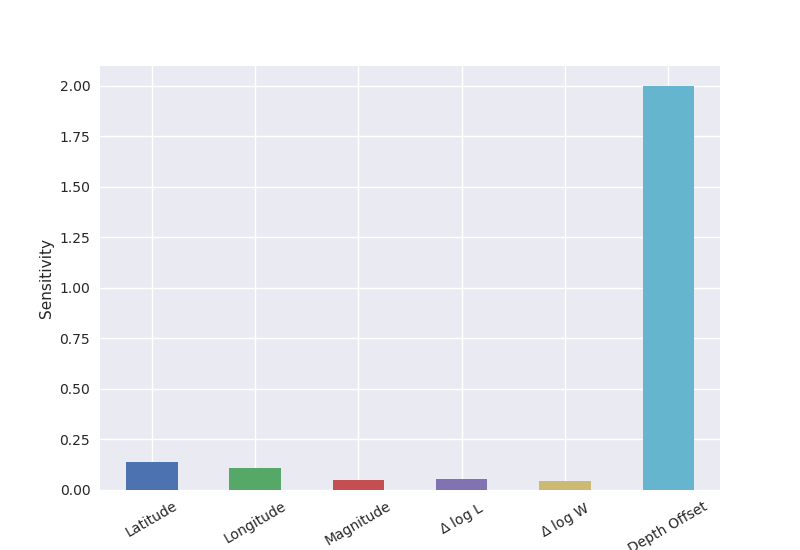

[Text(0,0.5,'Sensitivity')]

In [43]:
#Compute sensitivity bounds from equation (2.39)
#for perturbation by first singular vector
#(in which case variance is the first singular value)

nthin = 1 #optional thinning of sample data

normv = 0.1 #size of relative perturbation

sensDF = pd.DataFrame(columns = ['Parameter', 'Variance', 'Sensitivity'])

cols = samples[0].columns
ncol = len(cols)

for attr in cols:
    f = np.concatenate([ df[attr].values for df in samples ])
    f = f[::nthin]
    fvar = np.var(f)
    
    #Equation (2.39)
    sens = np.sqrt(fvar*s[0])*normv

    sensDF = sensDF.append({ 'Parameter' : attr, 'Variance': fvar, 'Sensitivity' : sens }, ignore_index = True)

sensDF['Parameter'] = [col.replace("_"," ").replace("log","log ").title().replace("Log","log").replace("Delta","$\Delta$") for col in cols]; 
#ylabs[3]="Delta log L"; ylabs[4]="Delta log W"; ylabs[5]="Depth Offset"; 
print(sensDF.to_latex(index=False,escape=False,formatters={
    'Variance' : '{:.3f}'.format,
    'Sensitivity' : '{:.3f}'.format,
    }))

display(sensDF)

#ax = sensDF.loc[sensDF['Parameter'] != 'depth_offset',:].plot(kind='bar',x='Parameter',y='Sensitivity',legend=False)
ax = sensDF.plot(kind='bar',x='Parameter',y='Sensitivity',legend=False)
plt.xticks(rotation=30)
ax.set(ylabel="Sensitivity")

In [44]:
#Compute sensitivity bounds from equation (2.39)

nthin = 1 #optional thinning of sample data

sensDF = derivs.copy()
sensDF = sensDF.drop(['Derivative','FI','Perturbation'],axis=1)

cols = samples[0].columns
ncol = len(cols)

for j,attr in enumerate(cols):
    f = np.concatenate([ df[attr].values for df in samples ])
    f = f[::nthin]
    fvar = np.var(f)
    print('Variance for',attr,'is:',fvar)
    
    #Equation (2.39)
    sensDF['S_'+attr] = np.sqrt(fvar*sensDF['FI Rel'])

sensDF

Variance for latitude is: 0.06612089778644199
Variance for longitude is: 0.040124123692999156
Variance for magnitude is: 0.007577022591804167
Variance for delta_logl is: 0.010526227689505006
Variance for delta_logw is: 0.006174954661870555
Variance for depth_offset is: 14.482727059630047


,Name,Observation,Distribution,Parameter,Value,FI Rel,R 0.1,Sing Vec,S_latitude,S_longitude,S_magnitude,S_delta_logl,S_delta_logw,S_depth_offset
0,Pulu Ai,height,normal,mean,3,5.934323,0.029672,-0.151253,0.626405,0.487965,0.212048,0.249932,0.191427,9.270662
1,Pulu Ai,height,normal,std,0.8,2.504926,0.012525,0.086667,0.406974,0.317030,0.137767,0.162380,0.124370,6.023135
2,Ambon,height,normal,mean,1.8,12.370389,0.061852,0.364273,0.904401,0.704522,0.306155,0.360851,0.276381,13.384953
3,Ambon,height,normal,std,0.4,5.220269,0.026101,0.215592,0.587511,0.457667,0.198882,0.234414,0.179541,8.695041
4,Banda Neira,arrival,skewnorm,mean,15,14.081782,0.070409,0.447233,0.964935,0.751678,0.326647,0.385004,0.294880,14.280848
5,Banda Neira,arrival,skewnorm,std,5,1.949911,0.009750,-0.148076,0.359068,0.279711,0.121550,0.143266,0.109730,5.314134
6,Banda Neira,arrival,skewnorm,a,2,1.339251,0.006696,0.132278,0.297578,0.231811,0.100735,0.118732,0.090939,4.404089
7,Banda Neira,height,normal,mean,6.5,7.524758,0.037624,-0.014170,0.705368,0.549476,0.238779,0.281438,0.215558,10.439302
8,Banda Neira,height,normal,std,1.5,0.883588,0.004418,-0.006226,0.241710,0.188290,0.081823,0.096441,0.073866,3.577256
9,Banda Neira,inundation,normal,mean,185,2.663355,0.013317,-0.009685,0.419647,0.326902,0.142057,0.167437,0.128242,6.210687


<IPython.core.display.Javascript object>


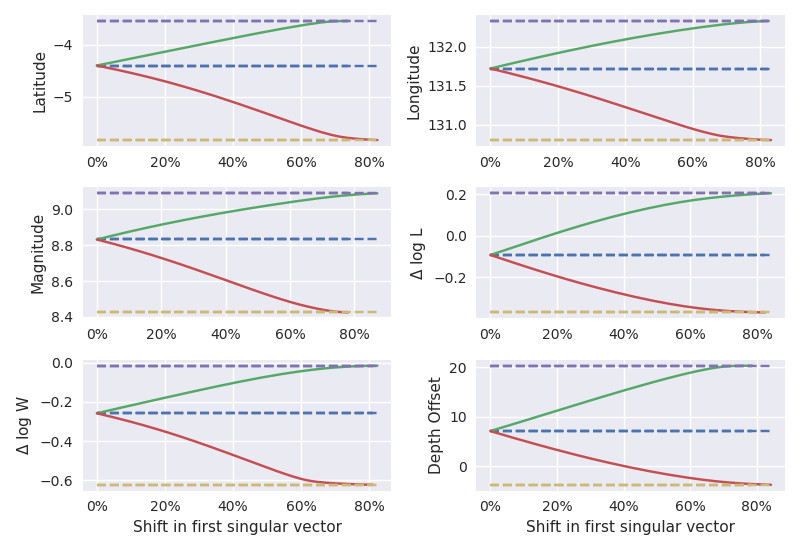

In [45]:
#regenerate the upper/lower bound figure, but in terms of shift by alpha*v_1, 
#where v_1 is the first singular vector

au = np.sqrt(2*Ru/s[0])*100
al = np.sqrt(2*Rl/s[0])*100

import matplotlib.ticker as mtick
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)

fig,axs = plt.subplots(3,2)
ylabs = [col.title() for col in cols]; ylabs[3]="Delta log L"; ylabs[4]="Delta log W"; ylabs[5]="Depth Offset"; 
for j,ax in enumerate(axs.ravel()):
    attr = ylabs[j]
    alph = np.concatenate((al[:,j],au[:,j]))
    ax.plot(alph,EPf[j]*np.ones_like(alph),'--',label='Mean')
    ax.plot(au[:,j],ub[:,j],label='Upper bound')
    ax.plot(al[:,j],lb[:,j],label='Lower bound')
    ax.plot(alph,fmax[j]*np.ones_like(R),'--',label='Max')
    ax.plot(alph,fmin[j]*np.ones_like(R),'--',label='Min')
    ax.set(ylabel=attr.replace("Delta","$\Delta$"))
    if j>3:
        ax.set(xlabel='Shift in first singular vector')
#     ax.set_xlim(0, 25)
    ax.xaxis.set_major_formatter(xticks)

plt.tight_layout()
plt.savefig('dupuis211_sv1.png')
plt.savefig('dupuis211_sv1.pdf')
plt.show()

<IPython.core.display.Javascript object>


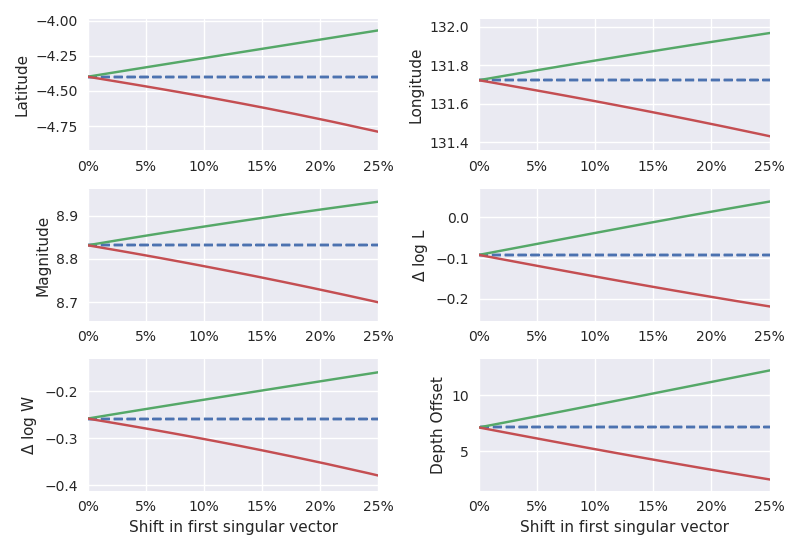

In [46]:
#regenerate the upper/lower bound figure, but in terms of shift by alpha*v_1, 
#where v_1 is the first singular vector

au = np.sqrt(2*Ru/s[0])*100
al = np.sqrt(2*Rl/s[0])*100
xmax = 25

import matplotlib.ticker as mtick
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)

fig,axs = plt.subplots(3,2)
ylabs = [col.title() for col in cols]; ylabs[3]="Delta log L"; ylabs[4]="Delta log W"; ylabs[5]="Depth Offset"; 
for j,ax in enumerate(axs.ravel()):
    attr = ylabs[j]
    idxu  = au[:,j]<=xmax+5
    idxl  = al[:,j]<=xmax+5
    alph = np.concatenate((al[:,j],au[:,j]))
    ax.plot(alph,EPf[j]*np.ones_like(alph),'--',label='Mean')
    ax.plot(au[idxu,j],ub[idxu,j],label='Upper bound')
    ax.plot(al[idxl,j],lb[idxl,j],label='Lower bound')
#     ax.plot(alph,fmax[j]*np.ones_like(R),'--',label='Max')
#     ax.plot(alph,fmin[j]*np.ones_like(R),'--',label='Min')
    ax.set(ylabel=attr.replace("Delta","$\Delta$"))
    if j>3:
        ax.set(xlabel='Shift in first singular vector')
    ax.set_xlim(0, xmax)
    ax.xaxis.set_major_formatter(xticks)

plt.tight_layout()
plt.savefig('dupuis211_sv1.png')
plt.savefig('dupuis211_sv1.pdf')
plt.show()